__mlmachine - Clean ML Experiments, Elegant EDA & Pandas Pipelines__
<br><br>
Check out the [GitHub repository](https://github.com/petersontylerd/mlmachine).
<br><br>

1. [What is mlmachine?](#What-is-mlmachine?)
1. [The Machine Class - A Hub With Many Spokes](#The-Machine-Class-A-Hub-With-Many-Spokes)
    1. [Data Intake](#Data-Intake)
    1. [mlm dtypes: Adding Feature Meaning to Pandas dtypes](#mlm-dtypes:-Adding-Feature-Meaning-to-Pandas-dtypes)
1. [Because EDA is Tedious and Takes Forever](#Because-EDA-is-Tedious-and-Takes-Forever)
    1. [Categorical Feature Panels](#Categorical-Feature-Panels)
        1. [Effortless Extension to Multi-class Problems](#Effortless-Extension-to-Multi-class-Problems)
    1. [Continuous Feature Panels](#Continuous-Feature-Panels)
        1. [Another Effortless Extension to Multi-class Problems](#Another-Effortless-Extension-to-Multi-class-Problems)
1. [Pandas In / Pandas Out Pipelines](#Pandas-In-/-Pandas-Out-Pipelines)
    1. [Scikit-learn Dismantles Pandas DataFrames](#Scikit-learn-Dismantles-Pandas-DataFrames)
    1. [Transformers, Now with DataFrames](#Transformers,-Now-with-DataFrames)
    1. [PandasFeatureUnion & DataFrameSelector - Intuitive, Familiar, Flexible](#PandasFeatureUnion-&-DataFrameSelector-Intuitive,-Familiar,-Flexible)
        1. [Vanilla FeatureUnion](#Vanilla-FeatureUnion)
        1. [PandasFeatureUnion & DataFrameSelector](#PandasFeatureUnion-&-DataFrameSelector)
            1. [Basic Example](#Basic-Example)
            1. [Less Basic Example](#Less-Basic-Example)
        1. [Updating mlm_dtypes](#Updating-mlm_dtypes)    

---
# What is mlmachine?
---
<br><br>
Notebooks often serve as scratch paper for data scientists. Machine learning experiments tend to become messy, disjointed series of hard-coded blocks. Even if time is taken to write general purpose functions, those functions live isolated, uselessly locked away from new projects.
<br><br>

mlmachine is a Python package that facilitates clean and organized notebook-based machine learning experimentation and accomplishes many key aspects of the experimentation life cycle.
<br><br>

The central hub of mlmachine is the `Machine()` class. A `Machine()` object retains the dataset, target data and feature meta data. More importantly, a `Machine()` object has numerous built-in methods for quickly executing key parts of the machine learning experiment workflow.
<br><br>

Here are a few of the core areas of mlmachine's functionality that we will explore in detail:
1. __Data intake & `mlm_dtype` identification__
2. __Exploratory data analysis__ - here is an example of just how easy it is to create a panel of visualizations and data summaries for a feature:

```python
# create single categorical feature EDA panel
mlmachine_demo.eda_cat_target_cat_feat(
    feature="Embarked",
    legend_labels=["Died","Survived"],
)
```
<br><br>
![alt text](images/p1_eda_panel.jpeg "EDA Panel")
<br><br>

3. __Pandas-friendly transformers and pipelines__ - see how simply wrapping the mlmachine utility `PandasTransformer()` around `OneHotEncoder()` maintains our `DataFrame`:
<br><br>

<br><br>
![alt text](images/p1_pandastransformer.jpeg "PandasTransformer")
<br><br>

mlmachine contains an immense amount of functionality aimed at saving time and improving model performance, all while keeping our keeping our workflow clean and organized.
<br><br>

Let's get started.
<br><br>

<a id = 'What-is-mlmachine?'></a>

---
# The Machine Class - A Hub With Many Spokes
---

<a id = 'The-Machine-Class-A-Hub-With-Many-Spokes'></a>

---
## Data Intake
---
<br><br>
We begin by instantiating a `Machine()` object:
<br><br>

<a id = 'Data-Intake'></a>

In [1]:
# import libraries
import numpy as np
import pandas as pd

# import mlmachine tools
import mlmachine as mlm
from mlmachine.data import titanic

# use titanic() function to create DataFrames for training and validation datasets
df_train, df_valid = titanic()

# instantiate a Machine object
mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name","Cabin"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings={"Pclass": [1, 2, 3]},
    is_classification=True,
)

~/.pyenv/versions/main37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


>>> category label encoding

	0 --> 0
	1 --> 1



---
<br><br>
Let's unpack what we just did. Using the canonical Titanic dataset, we instantiate a `Machine()` object, called `mlmachine_titanic`, by:
- Passing in the full dataset as a `DataFrame`
- Specifying the column that contains the target variable
- Specifying the supervised learning task as a classification task
<br><br>

The most basic purpose of `mlmachine_titanic` is to maintain our dataset of observations and our target values. Our dataset is stored as a `DataFrame` and can be accessed by calling `mlmachine_titanic.data`:
<br><br>

In [2]:
# review dataset
mlmachine_titanic.data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


---
<br><br>
Our target variable, stored as a named Pandas `Series`, can be accessed just as easily by calling `mlmachine_titanic.target`:
<br><br>

In [3]:
# review target values
mlmachine_titanic.target

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

---
<br><br>
The target values will be automatically label encoded, if needed.
<br><br>

We also passed several lists containing feature names to parameters such as `identify_as_continuous` and `identify_as_nominal`. Let's get into the purpose of these parameters.
<br><br>

---
## mlm dtypes: Adding Feature Meaning to Pandas dtypes
---
<br><br>
Pandas dtypes describe the values contained within a column, but have no regard for what the values actually _mean_. Nominal categories, ordinal categories, continuous numbers, counts…it's often impossible to make these distinctions from Pandas dtypes alone. 
<br><br>

In the mlmachine ecosystem, these distinctions are referred to as `mlm_dtypes`. mlmachine catalogs and, most importantly, updates `mlm_dtypes` as the dataset evolves through feature engineering.
<br><br>

Our dataset, stored as `mlmachine_titanic.data`, has a metadata attribute called `mlm_dtypes`:
<br><br>

<a id = 'mlm-dtypes:-Adding-Feature-Meaning-to-Pandas-dtypes'></a>

In [4]:
# review dataset's mlm dtypes
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Embarked', 'Sex'],
 'ordinal': ['Pclass'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Embarked', 'Sex', 'Pclass'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

---
<br><br>
This dictionary is a cornerstone of the mlmachine workflow and permeates throughout all of the package's functionality. Notice the dictionary's keys. Per the guidance we provided when instantiating the `Machine()` object, `mlm_dtypes` stores the mlm dtype for each feature.
<br><br>

The dictionary keys make it particularly easy to reference all features of a certain type without having to type out feature names. The practical benefit of this is obvious, especially if we consider datasets larger than this tiny Titanic dataset. 
<br><br>

In this article, we're going to leverage this efficiency in two key areas:
- Exploratory data analysis
- Transformations and pipelines
<br><br>

Let's put `mlm_dtypes` to use as we introduce mlmachine's exploratory data analysis capabilities.
<br><br>

---
# Because EDA is Tedious and Takes Forever
---
<br><br>
We're all guilty of performing a cursory EDA, if any at all ("let's just get to the model training!"). Even with all of the great Python visualization libraries out there, EDA can take a considerable amount of setup. Coding those same, slightly modified functions for the hundredth time is something we all do. And remembering which visualization types work best for which feature types and feature/target type combination is not easy.
<br><br>

Skipping EDA is absolutely a mistake, so a portion of mlmachine's functionality is dedicated to quickly making panels that are as beneficial as they are good looking.
<br><br>

<a id = 'Because-EDA-is-Tedious-and-Takes-Forever'></a>

---
## Categorical Feature Panels
---
<br><br>
We saw a teaser EDA panel in the introduction for the nominal category feature "Embarked". Let's go beyond this example by using our `mlm_dtypes` dictionary to quickly generate panels for all of our categorical features in `mlmachine_titanic.data`:
<br><br>

<a id = 'Categorical-Feature-Panels'></a>

Feature summary Feature vs. target summary Target proportion 
 
 
 Embarked 
 Count 
 Proportion 
 
 
 
 
 S 
 644 
 72.440945 
 
 
 C 
 168 
 18.897638 
 
 
 Q 
 77 
 8.661417 
 
 
 
 
 
 Embarked 
 Died 
 Survived 
 
 
 
 
 C 
 75 
 93 
 
 
 Q 
 47 
 30 
 
 
 S 
 427 
 217 
 
 
 
 
 
 Class 
 C 
 Q 
 S 
 
 
 
 
 Died 
 44.642857 
 61.038961 
 66.304348 
 
 
 Survived 
 55.357143 
 38.961039 
 33.695652

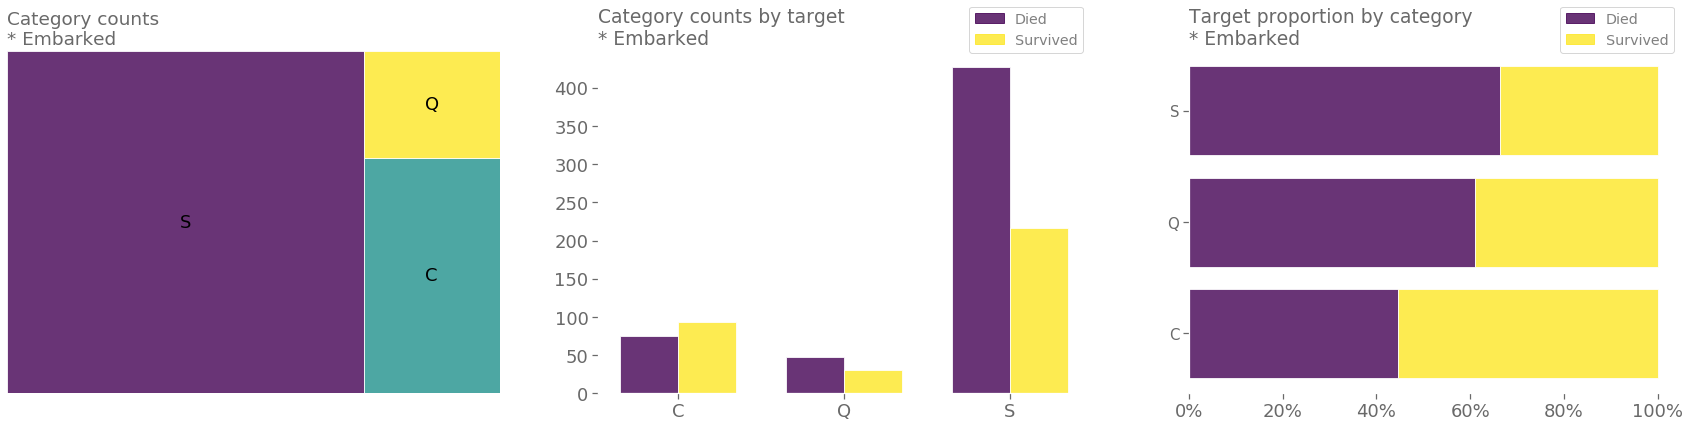

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 Sex 
 Count 
 Proportion 
 
 
 
 
 male 
 577 
 64.758698 
 
 
 female 
 314 
 35.241302 
 
 
 
 
 
 Sex 
 Died 
 Survived 
 
 
 
 
 female 
 81 
 233 
 
 
 male 
 468 
 109 
 
 
 
 
 
 Class 
 female 
 male 
 
 
 
 
 Died 
 25.796178 
 81.109185 
 
 
 Survived 
 74.203822 
 18.890815 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 16.2188 
 0.0

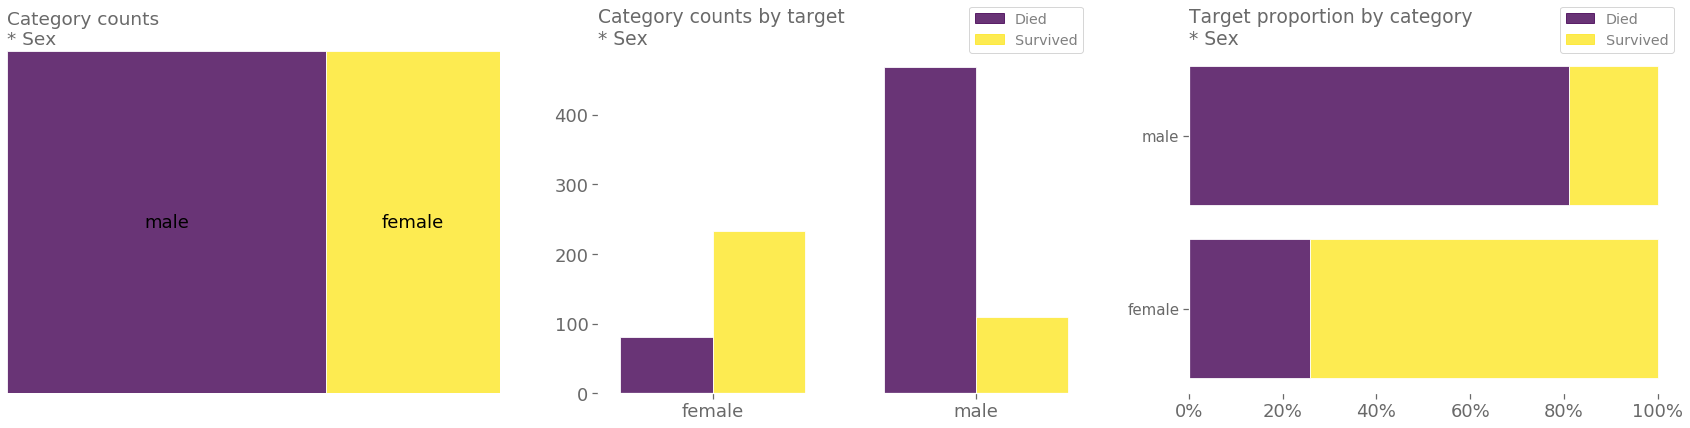

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass 
 Count 
 Proportion 
 
 
 
 
 3 
 491 
 55.106622 
 
 
 1 
 216 
 24.242424 
 
 
 2 
 184 
 20.650954 
 
 
 
 
 
 Pclass 
 Died 
 Survived 
 
 
 
 
 1 
 80 
 136 
 
 
 2 
 97 
 87 
 
 
 3 
 372 
 119 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

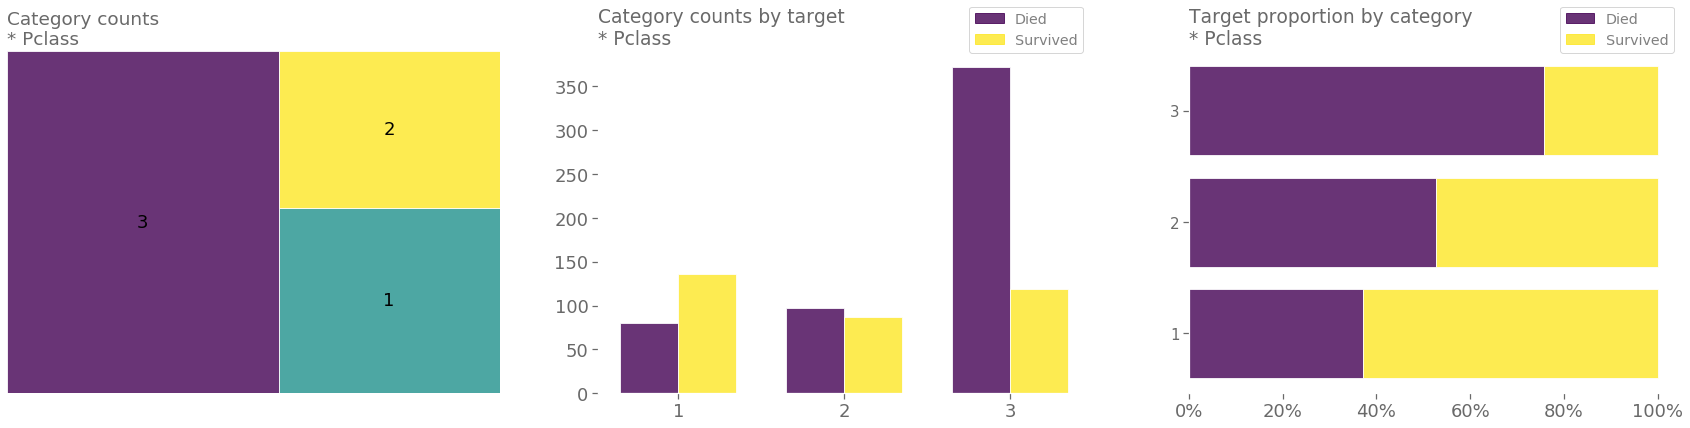

In [5]:
# create EDA panel for all "category" features
for feature in mlmachine_titanic.data.mlm_dtypes["category"]:
    mlmachine_titanic.eda_cat_target_cat_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
    )

---
<br><br>
`eda_cat_target_cat_feat()` generates an EDA panel for a categorical or count feature in the context of a categorical target. There are three summary tables at the top:
1. Feature Summary - Simple count of each level in the category, along with the percent of values each level constitutes in the feature.
2. Feature vs. target summary - Count of each level in the category, grouped by the classes in the target
3. Target proportion - The percent of values of a particular feature level, grouped by the classes in the target.
<br><br>

The panel includes three visualization. From left to right:
1. Tree map of the categorical feature.
2. Bar chart of the categorical feature, faceted by the target.
3. 100% horizontal stacked bar chart, faceted by the target.
<br><br>

---
### Effortless Extension to Multi-class Problems
---
<br><br>
Now let's use `eda_cat_target_cat_feat()` to generate a panel for a multi-class example. We'll use the Scikit-learn wine dataset to visualize a numeric feature called "alcalinity_of_ash" that has been segmented into 5 bins, effectively making it a categorical column:

<a id = 'Effortless-Extension-to-Multi-class-Problems'></a>

>>> category label encoding

	0 --> 0
	1 --> 1
	2 --> 2



Feature summary Feature vs. target summary Target proportion 
 
 
 alcalinity_of_ash_binned 
 Count 
 Proportion 
 
 
 
 
 3 
 42 
 23.595506 
 
 
 4 
 40 
 22.471910 
 
 
 1 
 36 
 20.224719 
 
 
 0 
 35 
 19.662921 
 
 
 2 
 25 
 14.044944 
 
 
 
 
 
 alcalinity_of_ash_binned 
 0 
 1 
 2 
 
 
 
 
 0 
 27 
 8 
 0 
 
 
 1 
 15 
 15 
 6 
 
 
 2 
 9 
 11 
 5 
 
 
 3 
 6 
 18 
 18 
 
 
 4 
 2 
 19 
 19 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 3 
 4 
 
 
 
 
 0 
 77.142857 
 41.666667 
 36.0 
 14.285714 
 5.0 
 
 
 1 
 22.857143 
 41.666667 
 44.0 
 42.857143 
 47.5 
 
 
 2 
 0.000000 
 16.666667 
 20.0 
 42.857143 
 47.5

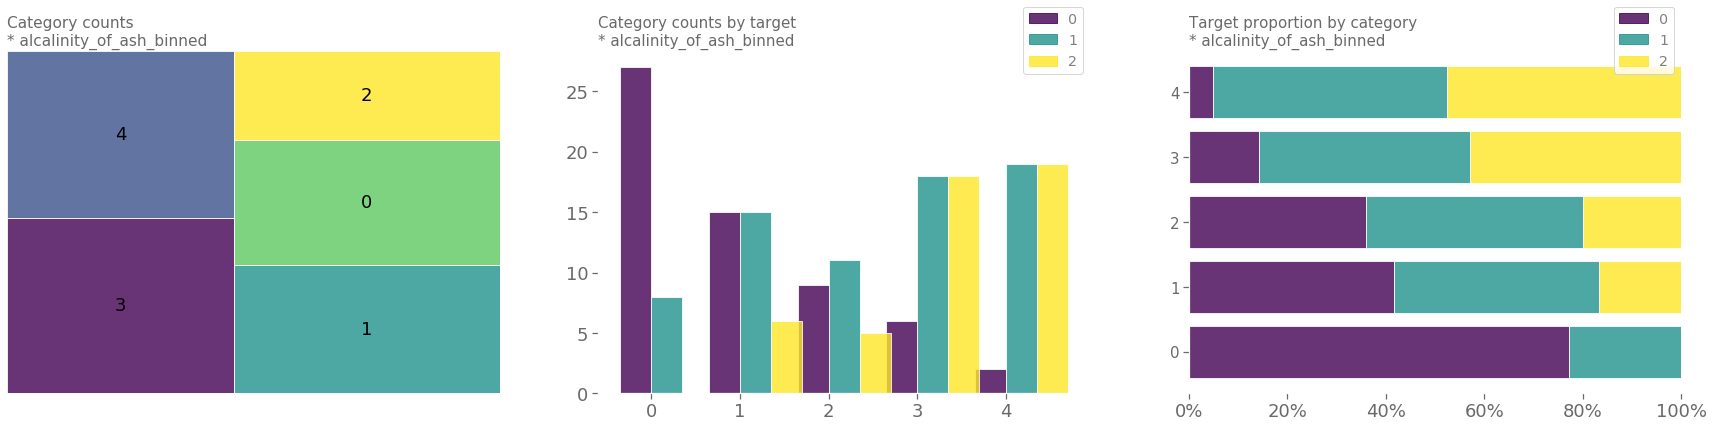

In [6]:
# import libraries
import sklearn.datasets as datasets
from sklearn.preprocessing import KBinsDiscretizer

# load wine dataset into DataFrame
dataset = datasets.load_wine()
dataset = pd.merge(
            pd.DataFrame(dataset.data, columns=dataset.feature_names),
            pd.Series(dataset.target, name="Class label"),
            left_index=True,
            right_index=True,
        )

# instantiate a Machine object
mlmachine_wine = mlm.Machine(
    data=dataset,
    identify_as_continuous=list(dataset.columns[:-1]),
    target="Class label",
    is_classification=True,
)

# instantiated object for creating 5 binned features
binner = KBinsDiscretizer(n_bins=5, encode="ordinal")

# transform continuous values of "alcalinity_of_ash" into 5 equal bins
mlmachine_wine.data["alcalinity_of_ash_binned"] = binner.fit_transform(
    mlmachine_wine.data["alcalinity_of_ash"].values.reshape(-1, 1)
)

# create single categorical feature EDA panel
mlmachine_wine.eda_cat_target_cat_feat(
    feature="alcalinity_of_ash_binned",
)

---
<br><br>
Each component of the panel adapts accordingly to the multi-class problem in this dataset.
<br><br>

---
## Continuous Feature Panels
---
<br><br>
Now let's see what mlmachine can do with numeric features:
<br><br>

<a id = 'Continuous-Feature-Panels'></a>

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 714.000000 
 
 
 mean 
 29.699118 
 
 
 std 
 14.526497 
 
 
 min 
 0.420000 
 
 
 25% 
 20.125000 
 
 
 50% 
 28.000000 
 
 
 75% 
 38.000000 
 
 
 max 
 80.000000 
 
 
 missing 
 177.000000 
 
 
 skew 
 0.388290 
 
 
 kurtosis 
 0.168637 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 424.0 
 59.383754 
 30.626179 
 14.155388 
 
 
 Survived 
 290.0 
 40.616246 
 28.343690 
 14.925152 
 
 
 
 
 
 z-test statistic 
 p-value 
 
 
 
 
 2.0667 
 0.0388

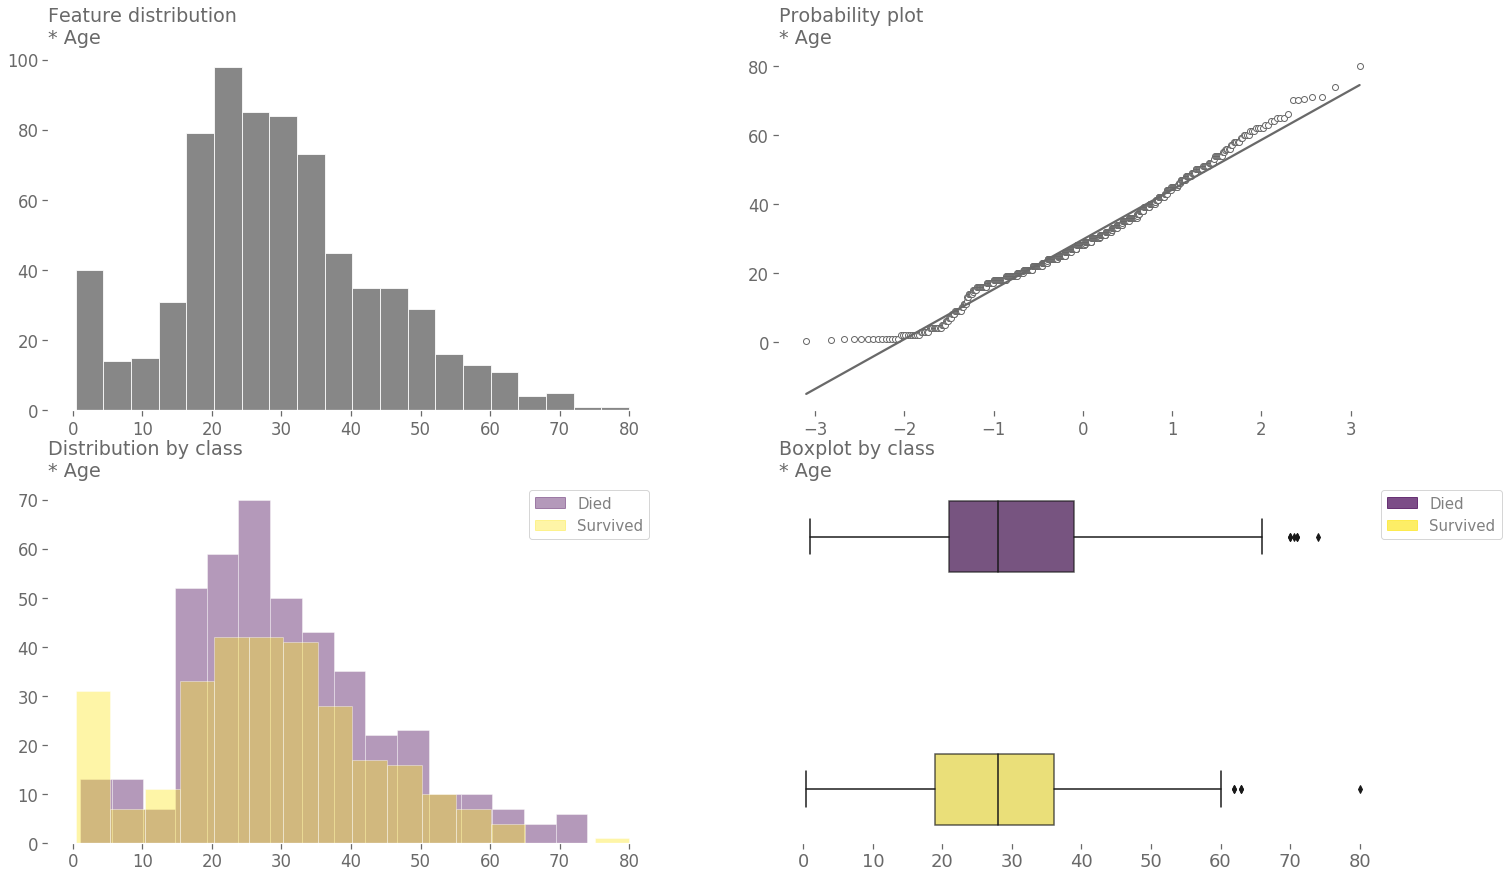

In [7]:
# create single numeric feature EDA panel
mlmachine_titanic.eda_cat_target_num_feat(
    feature="Age",
    legend_labels=["Died","Survived"],
)

---
<br><br>
`eda_cat_target_num_feat()` is a method that generates a panel for a numeric features in the context of a categorical target. At the top, we display three Pandas `DataFrames`:
1. Feature Summary - All of the summary statistics we get by executing the standard `df.describe()` command, plus "percent missing", "skew" and "kurtosis".
1. Feature vs. target summary - Count, proportion, mean and standard deviation of the numeric feature, grouped by the different classes in the target.
3. Statistical test - If the target column only has two classes, this reports the result of a z-test (or t-test, in the case of small samples) and the associated p-value.
<br><br>

Below the summary tables is a panel containing four visualizations. From left to right, starting in the top left corner:
1. Univariate distribution plot of the numeric feature.
2. QQ plot of the numeric feature.
3. Bivariate distribution plot of the numeric feature, faceted by the target.
4. Horizontal box plot, faceted by the target.

---
### Another Effortless Extension to Multi-class Problems
---
<br><br>
`eda_cat_target_num_feat()` also adapts to multi-class problems easily. Let's look at another quick example:
<br><br>

<a id = 'Another-Effortless-Extension-to-Multi-class-Problems'></a>

Feature summary,Feature vs. target summary
,alcalinity_of_ash
count,178.000000
mean,19.494944
std,3.339564
min,10.600000
25%,17.200000
50%,19.500000
75%,21.500000
max,30.000000
missing,0.000000


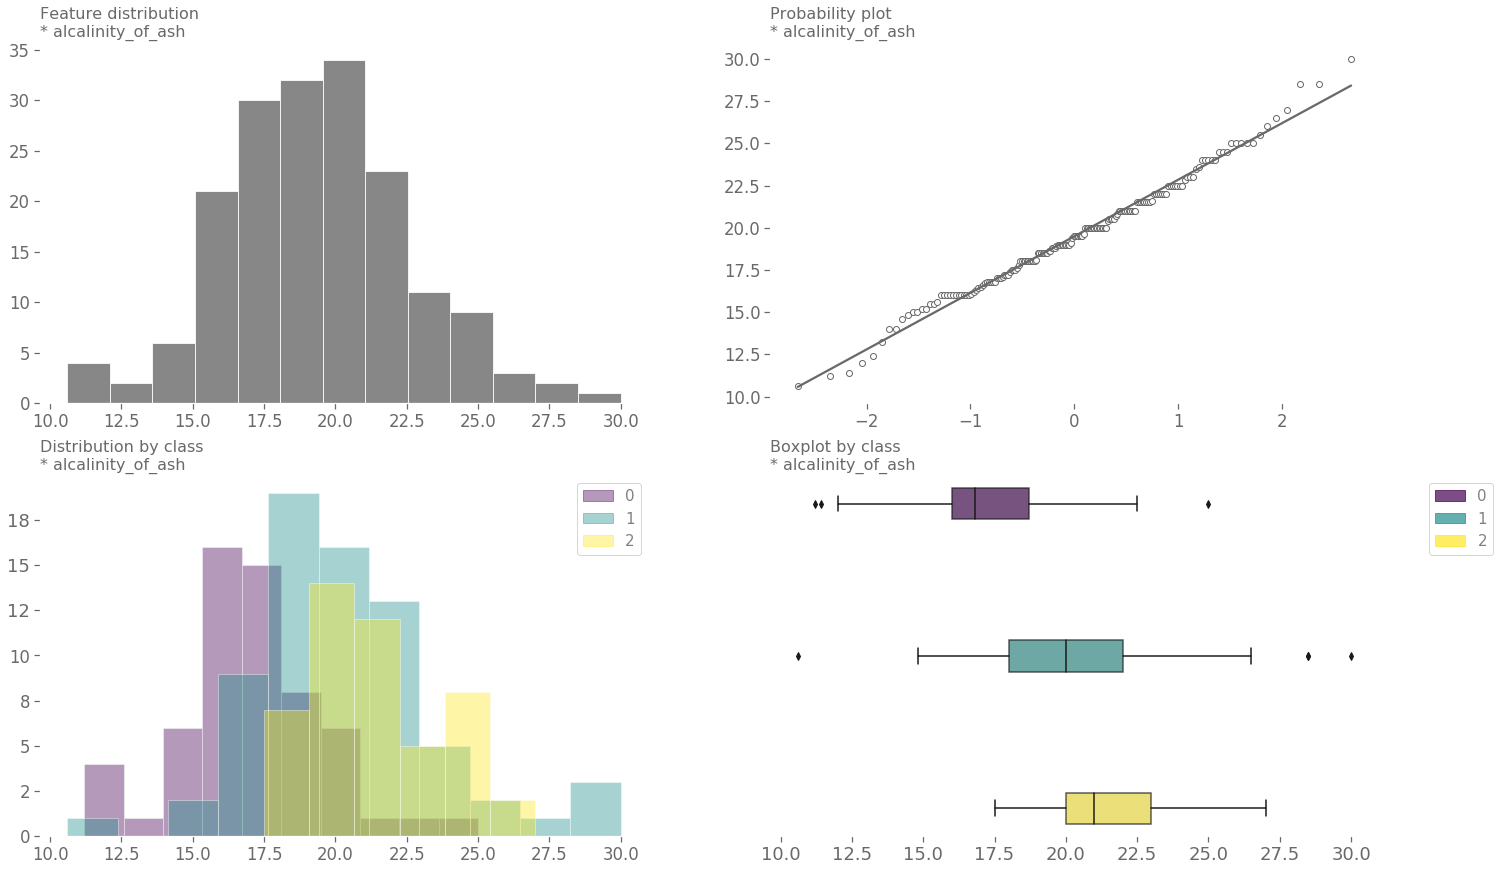

In [8]:
# create single numeric feature EDA panel
mlmachine_wine.eda_cat_target_num_feat(
    feature="alcalinity_of_ash",
)

---
<br><br>
We again create this panel using the Scikit-learn wine dataset with the same minimal code. Notice the changes:
1. The "Feature vs. target summary" table expands to reflect all three classes.
2. The faceted plots expand to visualize all three classes.
3. The x-axis and y-axis tick labels are decimals rather than whole numbers. This modification happens dynamically under the hood based on the scale of the data being visualized. Less time formatting, more time exploring.
<br><br>

mlmachine introduces an immense amount of simplicity and dynamism to EDA. Now let's see how mlmachine  facilitates a Pandas-friendly ML experimentation workflow.
<br><br>

---
# Pandas In / Pandas Out Pipelines
---

<a id = 'Pandas-In-/-Pandas-Out-Pipelines'></a>

---
## Scikit-learn Dismantles Pandas DataFrames
---
<br><br>
A major drawback of putting a `DataFrame` through an Scikit-learn transformer is the loss of the `DataFrame` wrapper around the underlying NumPy array. The issue is particularly pronounced with transformers like `PolynomialFeatures()`:
<br><br>
![alt text](images/p2_pandastransformer.jpeg "EDA Panel")
<br><br>
And if we think we've outsmarted this transformer by accessing the `poly.get_feature_names()` attribute, we'll be woefully disappointed once we see the output:
<br><br>
![alt text](images/p2_features.jpeg "EDA Panel")
<br><br>
Not helpful.
<br><br>

Due to this, we lose the ability to:
- Easily perform EDA on the transformed dataset
- Evaluate feature importance after training a model
- Use model explainability methods such as SHAP or LIME
- Merely identity which columns are which
<br><br>

Of course we could feed the NumPy array back into a `DataFrame`, and do whatever is needed to get the columns to match up, but…what a chore.
<br><br>

<a id = 'Scikit-learn-Dismantles-Pandas-DataFrames'></a>

---
## Transformers, Now with DataFrames
---
<br><br>
mlmachine leverages a class called `PandasTransformer()` to ensure that if a `DataFrame` passes into a transformer, a `DataFrame` comes out on the other side.
<br><br>

All we have to do was wrap `PolynomialFeatures()` with `PandasTransformer()` and we get a `DataFrame` with meaningful column names on the other side:

<br><br>
![alt text](images/p2_pandastransformer_2.jpeg "EDA Panel")
<br><br>

It's that easy.
<br><br>

Now that we've seen how to preserve our `DataFrame` when executing a single transformation, let's build on this with Scikit-learn's `Pipeline()` and `FeatureUnion()` functionality to perform multiple actions on multiple sets of features in one shot.
<br><br>

<a id = 'Transformers,-Now-with-DataFrames'></a>

---
## PandasFeatureUnion & DataFrameSelector - Intuitive, Familiar, Flexible
---

<a id = 'PandasFeatureUnion-&-DataFrameSelector-Intuitive,-Familiar,-Flexible'></a>

---
### Vanilla FeatureUnion
---
<br><br>
Scikit-learn includes a class called `FeatureUnion()`. To quote the documentation, `FeatureUnion()` "Concatenates results of multiple transformer objects…This is useful to combine several feature extraction mechanisms into a single transformer."
<br><br>

This is a great tool for applying different data processing actions to different features. For example, we may want to mean impute continuous features and mode impute categorical features:
<br><br>

<br><br>
![alt text](images/p2_featureunion.jpeg "EDA Panel")
<br><br>

Unfortunately, `FeatureUnion()` also suffers from the same disadvantage as other transformers - it returns a NumPy array. This is where `PandasFeatureUnion()` comes to the rescue.
<br><br>

<a id = 'Vanilla FeatureUnion'></a>

---
### PandasFeatureUnion & DataFrameSelector
---
<br><br>
Just like we need `PandasTransformer()` to retain the `DataFrame()` post-transformation, we need `PandasFeatureUnion()` to maintain the final `DataFrame` post-concatenation.
<br><br>

<a id = 'PandasFeatureUnion-&-DataFrameSelector'></a>

---
#### Basic Example
---

<a id = 'Basic-Example'></a>

In [9]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# import mlmachine tools
import mlmachine as mlm
from mlmachine.data import titanic

from mlmachine.features.preprocessing import (
    DataFrameSelector,
    PandasTransformer,
    PandasFeatureUnion,
)

# use titanic() function to create DataFrames for training and validation datasets
df_train, df_valid = titanic()

# instantiate a Machine object
mlmachine_titanic = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId","Ticket","Name"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Embarked","Cabin"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = {"Pclass": [1, 2, 3]},
    is_classification=True,
)

# create imputation PandasFeatureUnion pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Embarked","Cabin"])
    )),
])

# execute imputation
mlmachine_titanic.data = impute_pipe.fit_transform(mlmachine_titanic.data)

>>> category label encoding

	0 --> 0
	1 --> 1



In [10]:
mlmachine_titanic.data[:20]

,Age,Embarked,Cabin,Fare,Pclass,Sex,SibSp,Parch
0,22.0,S,X,7.2500,3,male,1,0
1,38.0,C,C85,71.2833,1,female,1,0
2,26.0,S,X,7.9250,3,female,0,0
3,35.0,S,C123,53.1000,1,female,1,0
4,35.0,S,X,8.0500,3,male,0,0
5,24.0,Q,X,8.4583,3,male,0,0
6,54.0,S,E46,51.8625,1,male,0,0
7,2.0,S,X,21.0750,3,male,3,1
8,27.0,S,X,11.1333,3,female,0,2
9,14.0,C,X,30.0708,2,female,1,0


---
<br><br>
We start fresh here by again instantiating a `Machine()` object called `mlmachine_titanic`. Then we use mlmachine's `PandasFeatureUnion()` class to create a `DataFrame`-friendly, `FeatureUnion`-style pipeline called `impute_pipe`. Specifically, we perform three different types of imputations on three different columns.
- Impute "Age" with the mean
- Impute "Embarked" with the mode
- Impute "Cabin" with a constant value (X).
<br><br>

A keen observer will notice the presence of another class - `DataFrameSelector()` - within each pipeline. This class is an essential element of the `PandasFeatureUnion()` workflow, and serves different purposes depending on how it's used. On lines 30, 34 and 38, `DataFrameSelector()` is used to select the column for that particular branch of the union. The columns are selected by name using the `include_columns` parameter.
<br><br>

On line 42, we do something a bit different. Since `FeatureUnion()` operations, by design, act on specific columns and concatenate the results, we would be left with only the transformed columns without further intervention.
<br><br>

That is why `DataFrameSelector()` has the flexibility to select all columns except those specified. By way of the `exclude_columns` parameter, we select all features except for the features we imputed. This ensures we keep our full dataset.
<br><br>

Now that we have filled in our nulls values, let's advance to a slightly more complicated preprocessing step using the `PandasFeatureUnion()` workflow. And if there is any question about the purpose of `mlm_dtypes`, that will become even clearer right now.
<br><br>

---
#### Less Basic Example
---

<a id = 'Less-Basic-Example'></a>

In [11]:
# import libraries
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# create encoding PandasFeatureUnion pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(
            include_mlm_dtypes=["nominal"],
            exclude_columns=["Cabin"]
        ),
        PandasTransformer(OneHotEncoder())
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["ordinal"]),
        PandasTransformer(
            OrdinalEncoder(categories=list(mlmachine_titanic.ordinal_encodings.values()))
        )
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(
            exclude_columns=[i for i in mlmachine_titanic.data.mlm_dtypes["nominal"] if i != "Cabin"]\
            + list(mlmachine_titanic.ordinal_encodings.keys())
        )
    )),
])

# execute encoding
mlmachine_titanic.data = encode_pipe.fit_transform(mlmachine_titanic.data)

In [12]:
mlmachine_titanic.data[:20]

,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_ordinal_encoded,Age_binned_5,Fare_binned_5,Cabin,Fare,Age,SibSp,Parch
0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,X,7.2500,22.0,1,0
1,1.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,C85,71.2833,38.0,1,0
2,0.0,0.0,1.0,1.0,0.0,2.0,2.0,1.0,X,7.9250,26.0,0,0
3,0.0,0.0,1.0,1.0,0.0,0.0,3.0,4.0,C123,53.1000,35.0,1,0
4,0.0,0.0,1.0,0.0,1.0,2.0,3.0,1.0,X,8.0500,35.0,0,0
5,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,X,8.4583,24.0,0,0
6,0.0,0.0,1.0,0.0,1.0,0.0,4.0,4.0,E46,51.8625,54.0,0,0
7,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,X,21.0750,2.0,3,1
8,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,X,11.1333,27.0,0,2
9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,X,30.0708,14.0,1,0


---
<br><br>
We now have a DataFrame with encoded columns, all clearly named. Let's take this `PandasFeatureUnion` branch by branch:
- "nominal" pipeline - Here we see the flexibility of `DataFrameSelector()`. First, we select all nominal columns by passing `["nominal"]` to the `include_mlm_dtypes` parameter. `DataFrameSelector()` directly references `mlm_dtypes` to make column selections. Second, we exclude "Cabin" (also a nominal feature) by passing the feature name to the `exclude_columns` parameter. `DataFrameSelector()` reconciles our include/exclude specifications by selecting all nominal columns except "Cabin". Lastly, we pass our selected columns to `OneHotEncoder()`, wrapped in `PandasTransformer()`.
<br><br>

- "ordinal" pipeline - We again us the `DataFrameSelector()` parameter `include_mlm_dtypes`, this time to select all ordinal columns. Then we pass our result to `OrdinalEncoder()`, wrapped in `PandasTransformer()`. We also provide encoding instructions. When we instantiated our `Machine()` object, we passed in a dictionary called `ordinal_encodings`, which `mlmachine_titanic` stores as an attribute. We wrap this dictionary's values in a list and pass it to the `OrdinalEncoder()` parameter `categories`. This will ensure the desired hierarchy is enforced during encoding.
<br><br>

- "bin" pipeline - We again use `include_mlm_dtypes` to select all continuous features and pass the result to `KBinsDiscretizer()`, wrapped in `PandasTransformer()`.
<br><br>

- "diff" pipeline - The last step is to recombine any features that would otherwise be lost in the union operation, and drop any features we no longer need. We perform a list comprehension on the `mlm_dtypes` attribute to remove "Cabin", and append the keys of `mlmachine_titanic.ordinal_encodings` to the result. This will ensure that the original nominal and ordinal features are not in the transformed dataset, but that we retain "Cabin". Notice that we do not exclude the continuous columns, despite the fact we transformed these features with `KBinsDiscretizer()`. The reason is simple - we want to keep the original continuous columns in our dataset.

We call `encode_pipe` with the familiar `fit_transform()` method.

---
### Updating mlm_dtypes
---
<br><br>
Since we have new features in the dataset, it is best practice to follow `fit_transform()` with `update_mlm_dtypes()`:
<br><br>

In [13]:
# update mlm_dtypes
mlmachine_titanic.update_dtypes()

In [14]:
mlmachine_titanic.data.mlm_dtypes

{'boolean': [],
 'nominal': ['Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Sex_female',
  'Sex_male'],
 'ordinal': ['Age_binned_5', 'Fare_binned_5', 'Pclass_ordinal_encoded'],
 'continuous': ['Age', 'Fare'],
 'count': ['Parch', 'SibSp'],
 'string': [],
 'date': [],
 'category': ['Age_binned_5',
  'Cabin',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_S',
  'Fare_binned_5',
  'Pclass_ordinal_encoded',
  'Sex_female',
  'Sex_male'],
 'number': ['Age', 'Fare', 'Parch', 'SibSp']}

---
<br><br>
As alluded to earlier in this article, we can update `mlm_dtypes` to reflect the current state of the data attribute. Let see a before-and-after to clearly see how `mlm_dtypes` dictionary changed:
<br><br>

<br><br>
![alt text](images/p1_mlm_dtypes.jpeg "EDA Panel")
<br><br>

Our updated `mlm_dtypes` dictionary is on the right. We see that the nominal columns "Embarked" and "Sex" are absent, and in their place we see names for dummy columns, such as "Embarked_C" and "Sex_male", resulting from `PandasTransformer(OneHotEncoder())`. Also notice that the "nominal" key  still contains the "Cabin" feature, which we chose to leave unprocessed at this point. 
<br><br>

The "ordinal" key contains our binned versions of "Age" and "Fare", as well as "Pclass", which has been named in a way that clearly indicates the type of encoding applied. 
<br><br>

Whenever we modify `data`, we simply call `update_mlm_dtypes()`, and `mlm_dtypes` will automatically update to reflect the current state of the dataset. The only real effort is to identify the mlm dtype for each feature from the outset, which is something we should do every time anyway.
<br><br>

<a id = 'Updating-mlm_dtypes'></a>

---
<br><br>
Let's bring things to a conclusion by leveraging the `mlm_dtypes` dictionary to quickly perform a little EDA on our new features. This time, we'll cycle through all of our ordinal features:
<br><br>

<a id = 'In-Closing'></a>

Feature summary,Feature vs. target summary,Target proportion
Age_binned_5,Count,Proportion
2,267,29.966330
3,189,21.212121
4,188,21.099888
0,164,18.406285
1,83,9.315376
Age_binned_5,Died,Survived
0,85,79
1,59,24
2,177,90


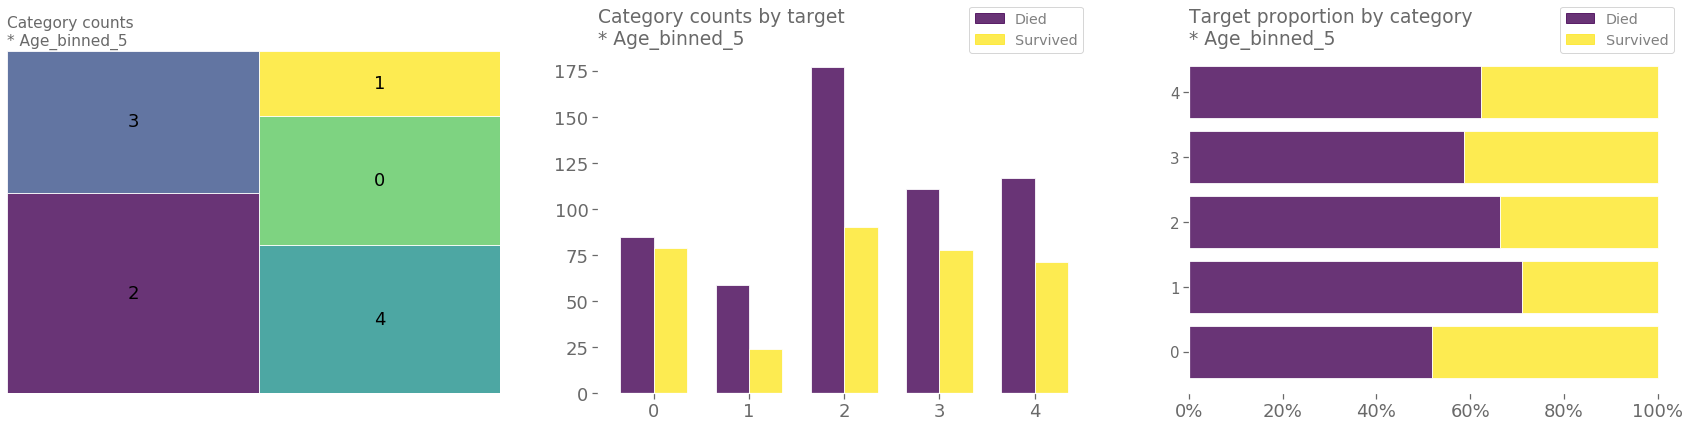

Feature summary,Feature vs. target summary,Target proportion
Fare_binned_5,Count,Proportion
2,195,21.885522
4,182,20.426487
3,175,19.640853
1,173,19.416386
0,166,18.630752
Fare_binned_5,Died,Survived
0,130,36
1,142,31
2,113,82


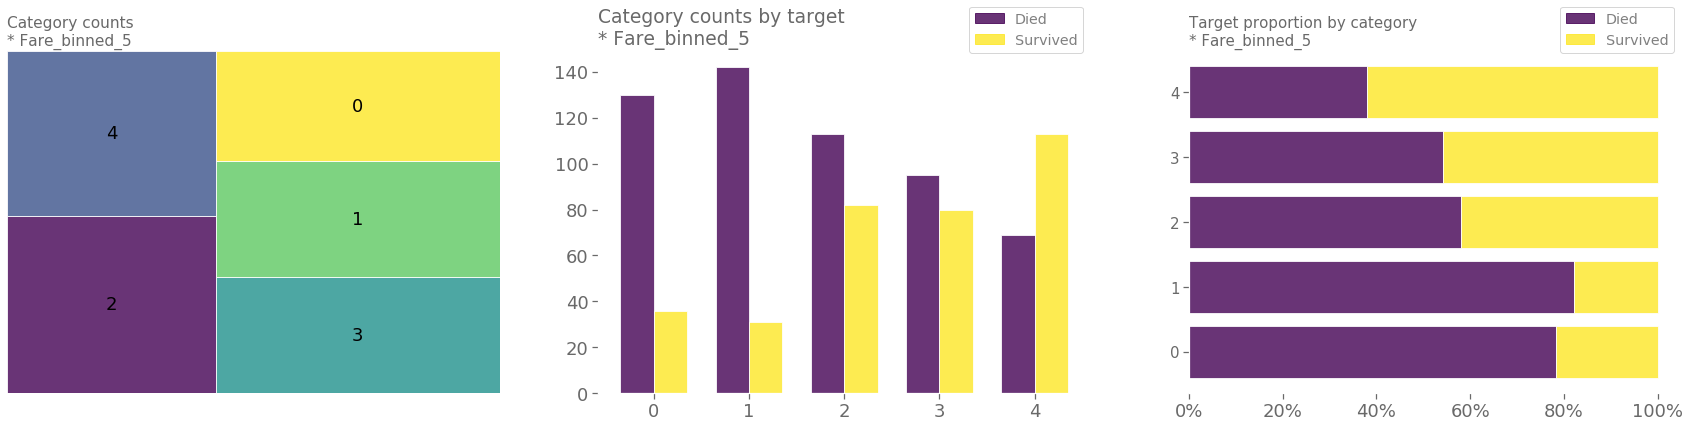

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass_ordinal_encoded 
 Count 
 Proportion 
 
 
 
 
 2 
 491 
 55.106622 
 
 
 0 
 216 
 24.242424 
 
 
 1 
 184 
 20.650954 
 
 
 
 
 
 Pclass_ordinal_encoded 
 Died 
 Survived 
 
 
 
 
 0 
 80 
 136 
 
 
 1 
 97 
 87 
 
 
 2 
 372 
 119 
 
 
 
 
 
 Class 
 0 
 1 
 2 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

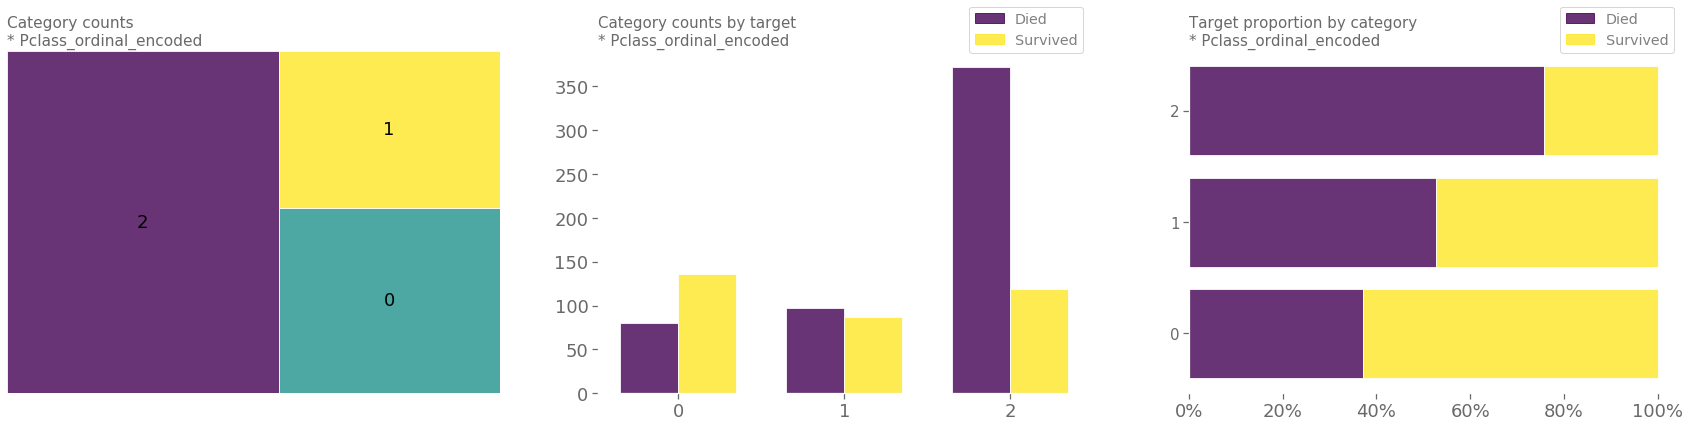

In [15]:
# create EDA panel for all "ordinal" features
for feature in mlmachine_titanic.data.mlm_dtypes["ordinal"]:
    mlmachine_titanic.eda_cat_target_cat_feat(
        feature=feature,
        legend_labels=["Died","Survived"],
    )

---
<br><br>
Star the [GitHub repository](https://github.com/petersontylerd/mlmachine), and stay tuned for additional notebooks.
<br><br>